<img src='./img/logo_fire_workshop.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="./52_sentinel3_olci_rgb.ipynb"><< 52 - Sentinel 3 OLCI RGB </a><span style="float:right;"><a href="./62_case_study_sweden_fires_summer_2018_self_paced.ipynb">62 - Case study Sweden Fires - Summer 2018 >></a></span>

# Case study - Siberian fires - Summer 2019

Summer 2019 was one of the hottest on record in the Arctic Circle, according to the Copernicus Climate Change service. In June and July there were more than 100 intense and long-lived wildfires in the Arctic Circle.

In late July wildfires raged for days in various regions of the Arctic and Siberia. These fires were unprecedented in duration, extent and emissions. Read more about the Artic fires [here](https://www.eumetsat.int/website/home/Images/ImageLibrary/DAT_4505427.html).

The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the following data products:

- [GOME-2 Metop-A/B Aersol Absorbing Index](#gome2_aai)
- [Sentinel-5P TROPOMI Aerosol Index](#sentinel_5p_ai)
- [IASI Total Column Carbon Monoxide](#iasi_co)
- [Sentinel-5P TROPOMI Carbon Monoxide](#sentinel_5p_co)


- [CAMS GFAS Wildfire Radiative Power](#cams_gfas)
- [CAMS Total Column Carbon Monoxide](#cams_co)


- [GEFF Fire Weather Index](#geff_fwi)


- [LSA SAF data products for fire monitoring](#lsa_saf)


- [Sentinel-3 OLCI RGB](#sentinel3_olci)



<hr>

#### Load required libraries

In [60]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd
import h5py

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [61]:
from ipynb.fs.full.functions import load_l2_data_xr, generate_masked_array, generate_xr_from_1D_vec, visualize_imshow, visualize_pcolormesh, visualize_l2, select_channels_for_rgb, normalize, visualize_s3_pcolormesh, hdrdtypelib


<hr>

## <a id='gome2_aai'></a>GOME-2 Metop-B Absorbing Aerosol Index (AAI)

#### Load the data with the function `load_l2_data_xr`

Let's load the data file from 23 July 2019 with the function [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr).

In [62]:
directory_aai_2b = './eodata/gome2/offline/2b/2019/07/23/'
aai_b_da_mf = load_l2_data_xr(directory_aai_2b, 'hdf5', 'DATA', 'AAI','GEOLOCATION/LatitudeCenter','GEOLOCATION/LongitudeCenter',
                              no_of_dims=2, paramname='AAi', longname='Absorbing Aerosol Index', unit='-')
aai_b_da_mf

<xarray.DataArray 'AAi' (ground_pixel: 2142208)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 46.5238 46.851673 ... -69.07906
    longitude     (ground_pixel) float32 -64.23352 -64.454346 ... 49.443115
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 561 562 563 564 565 566
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

#### Load SunGlintFlag

The `SunGlintFlag` information should be used to flag out not valid entries. You can load the `SunGlintFlag` information as well with the function [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr).

In [63]:
sg_b_da_mf = load_l2_data_xr(directory_aai_2b, 'hdf5', 'DATA', 'SunGlintFlag','GEOLOCATION/LatitudeCenter','GEOLOCATION/LongitudeCenter',
                             no_of_dims=2, paramname='SunGlint', longname='Sun Glint', unit='-')
sg_b_da_mf

<xarray.DataArray 'SunGlint' (ground_pixel: 2142208)>
array([-999, -999, -999, ..., -999, -999, -999], dtype=int32)
Coordinates:
    latitude      (ground_pixel) float32 46.5238 46.851673 ... -69.07906
    longitude     (ground_pixel) float32 -64.23352 -64.454346 ... 49.443115
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 561 562 563 564 565 566
Attributes:
    long_name:  Sun Glint
    units:      -

#### Mask the data array with the `SunGlintFlag` information

The function [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array) allows you to mask out the non-valid data entries based on the loaded sun glint flag array. The mask removes all entries where the sun glint flag equals 0.

In [64]:
aai_masked = generate_masked_array(aai_b_da_mf, sg_b_da_mf, 0, '=')
aai_masked

<xarray.DataArray (ground_pixel: 2142208)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 46.5238 46.851673 ... -69.07906
    longitude     (ground_pixel) float32 -64.23352 -64.454346 ... 49.443115
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 561 562 563 564 565 566


<xarray.DataArray (ground_pixel: 1792863)>
array([ 0.5772649 , -0.625435  , -0.07986939, ...,  0.31253183,
        0.85698164,  0.99602187], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 56.08949 56.396343 ... -58.360085
    longitude     (ground_pixel) float32 -72.435036 -72.777664 ... 51.039883
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 29 30 31 32 34 35 ... 532 533 534 535 536
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

#### Visualize the data in `Orthographic` projection with the function `visualize_l2`

The function [visualize_l2](./ltpy_functions.ipynb#visualize_l2) allows to change between different projections. The `ccrs.Orthographic()` projection is advantageous to highlight some phenomena close to the poles.

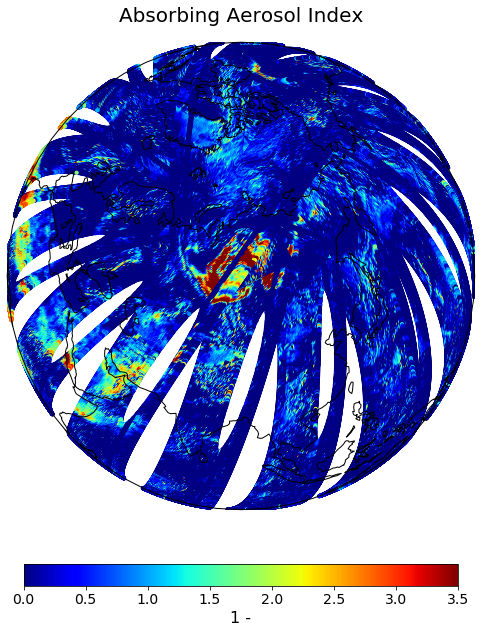

In [65]:
visualize_l2(aai_masked,1,ccrs.Orthographic(90,60),0,3.5,10,'jet', aai_masked.units, aai_masked.long_name, False)

<br>

## <a id='sentinel_5p_ai'></a>Copernicus Sentinel-5p TROPOMI Aerosol Index

Let's load the Sentinel-5p TROPOMI Aerosol Index data with xarray's function `open_mfdataset()`

In [66]:
s5p_mf = xr.open_mfdataset('./eodata/sentinel5p/UVAI/2019/07/23/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf

<xarray.Dataset>
Dimensions:                          (corner: 4, ground_pixel: 450, scanline: 6490, time: 1)
Coordinates:
  * time                             (time) datetime64[ns] 2019-07-23
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
  * scanline                         (scanline) float64 0.0 1.0 ... 3.244e+03
    latitude                         (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
    longitude                        (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
Data variables:
    delta_time                       (time, scanline) datetime64[ns] dask.array<chunksize=(1, 3245), meta=np.ndarray>
    time_utc                         (time, scanline) object dask.array<chunksize=(1, 3245), meta=np.ndarray>
    qa_value                         (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 450), meta=np.ndarray>

#### Select aerosol index data together with latitude and longitude information 

In [67]:
uvai = s5p_mf.aerosol_index_340_380[0,:,:]
lat = uvai.latitude
lon = uvai.longitude


#### Load the `qa_value` for quality assurance

In [68]:
qa=s5p_mf.qa_value[0,:,:]

#### Mask the data based on a `qa_value` higher than 0.8

In [69]:
uvai_masked=uvai.where(qa > 0.8)

#### Define some variables for plotting

In [70]:
unit = uvai.units
long_name = uvai.long_name
vmin = 1.0
vmax = 4

latmin=-10
latmax=90
lonmin=40
lonmax=180

#### Visualize the masked AAI data with the function `visualize_pcolormesh`

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f665879d7f0>)

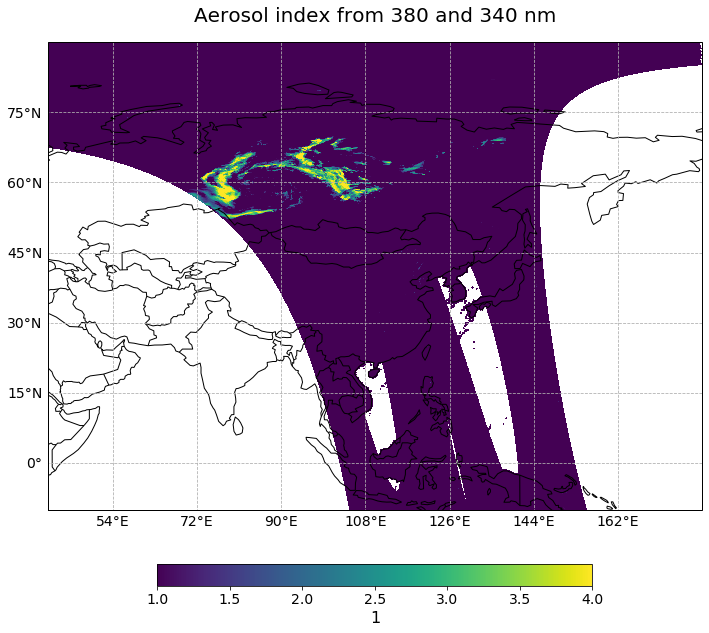

In [71]:
visualize_pcolormesh(uvai_masked, 
                     lon, 
                     lat, 
                     ccrs.PlateCarree(), 
                     'viridis', 
                     unit, 
                     long_name, 
                     vmin, 
                     vmax, 
                     lonmin, 
                     lonmax, 
                     latmin, 
                     latmax, 
                     log=False, 
                     set_global=False)

## <a id='iasi_co'></a>IASI Total Column Carbon Monoxide

#### Load the data file with `pandas`

IASI Total Column Carbon Monoxide data are disseminated in `.txt` format. You can easily load the .txt file with `pandas`, using an empty string as seperator.

Pandas' function `.head()` shows you the first entries of the loaded file.

In [72]:
iasi_file = './eodata/iasi/txt/co/2b/2019/07/23/iasi_CO_LATMOS_ULB_metopb_20190723_v20151001.txt'


In [73]:
iasi_co = pd.read_csv(iasi_file, sep=" ", header = None)
iasi_co.head()

0         1         2    3       4   5   6   7   8   9   ...  \
0 -5.28564 -46.54831  20190723  258  131.61   0   1   0   0   0  ...   
1 -5.03226 -46.60137  20190723  258  131.46   1   1   0   0   0  ...   
2 -5.13056 -47.08466  20190723  258  131.06   2   1   0   0   1  ...   
3 -5.02433 -45.42467  20190723  258  132.54   0   1   0   0   0  ...   
4 -4.79073 -45.47406  20190723  258  132.41   1   1   0   0   0  ...   

         50        51        52        53        54        55        56  \
0  1.967916  1.981760  1.927175  1.811883  1.661120  1.486958  1.294062   
1  1.892960  1.873258  1.791627  1.660121  1.500409  1.325970  1.138707   
2  2.180583  2.258604  2.246180  2.152696  2.011326  1.838382  1.635759   
3  2.064783  2.093467  2.059924  1.965963  1.823733  1.650130  1.454150   
4  1.991248  1.993741  1.934715  1.820194  1.668977  1.496648  1.306471   

         57        58        59  
0  1.093281  0.894955 -0.061292  
1  0.948803  0.766456 -0.042892  
2  1.414180  1.182802 -0.108790  
3  1.245359  1.032613 -0.111512  
4  1.108603  0.910080 -0.080651  

[5 rows x 60 columns]

#### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function [generate_xr_from_1D_vec](./ltpy_functions.ipynb#generate_xr_from_1D_vec) to load the `Total Column Carbon Monoxide` information into a xarray.

The data holds a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information into a xarray.

In [74]:
iasi_co_da = generate_xr_from_1D_vec(iasi_co,0, 1, iasi_co[20], 'co', 'IASI Carbon Monoxide Total Column', 1, 'molec./cm-2')

In [75]:
iasi_co_qf_da = generate_xr_from_1D_vec(iasi_co,0, 1, iasi_co[15], 'qf', 'Super Quality Flag', 1, '-')

#### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array) allows you to flag out the quality flags. If the quality flag is 0, the data values are flagged.

In [76]:
iasi_co_masked = generate_masked_array(iasi_co_da,iasi_co_qf_da,0,'=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 548815)>
array([1.860367e+18, 1.897558e+18,          nan, ..., 1.471667e+18,
       1.455511e+18, 1.435054e+18])
Coordinates:
    latitude   (ground_pixel) float64 -5.286 -5.032 -5.131 ... 71.52 71.47 71.26
    longitude  (ground_pixel) float64 -46.55 -46.6 -47.08 ... -45.23 -45.12
Dimensions without coordinates: ground_pixel


<xarray.DataArray (ground_pixel: 413517)>
array([1.860367e+18, 1.897558e+18, 2.009047e+18, ..., 1.471667e+18,
       1.455511e+18, 1.435054e+18])
Coordinates:
    latitude   (ground_pixel) float64 -5.286 -5.032 -5.024 ... 71.52 71.47 71.26
    longitude  (ground_pixel) float64 -46.55 -46.6 -45.42 ... -45.23 -45.12
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

#### Visualize the masked dataset with the function `visualize_l2`

You can visualize the IASI Total Column Carbon Monoxide data again with the function [visualize_l2](./ltpy_functions.ipynb#visualize_l2) and an `Orthographic()` projection and focus on the region over Siberia.

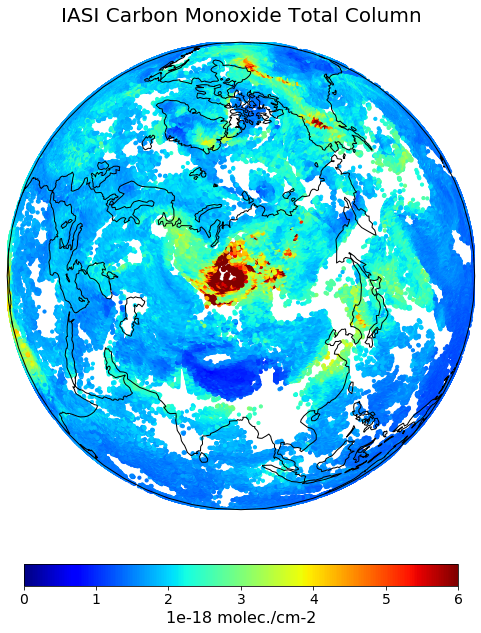

In [77]:
visualize_l2(iasi_co_masked, 
             1e-18,
             ccrs.Orthographic(90,60), 
             0, 6, 
             10, 
             'jet', 
             iasi_co_masked.units, 
             iasi_co_masked.long_name,  )

<br>

Let's also visualize the same example, but in a `PlateCarree()` projection.

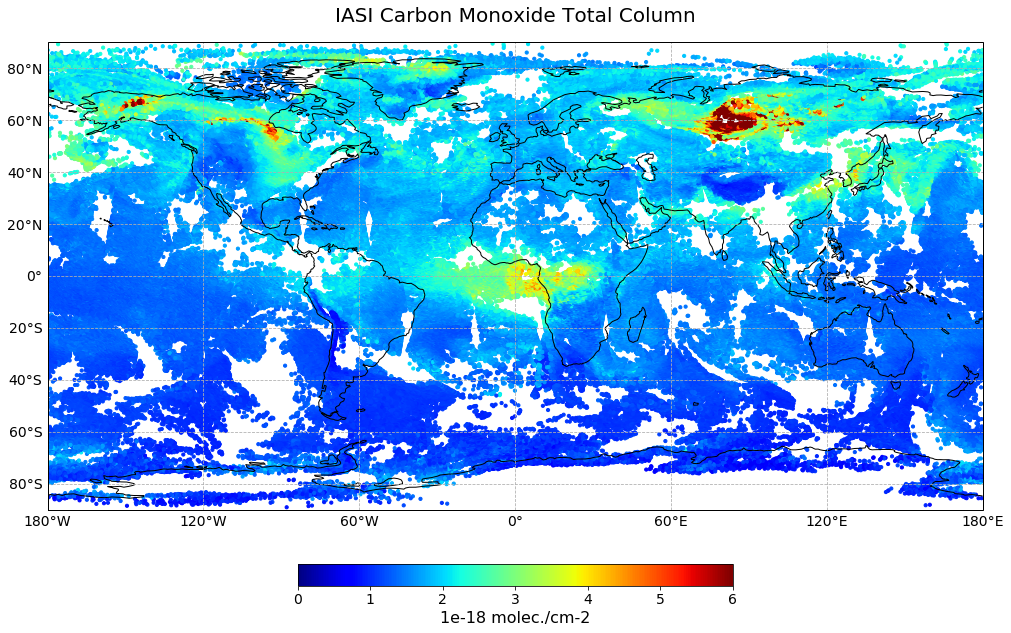

In [78]:
visualize_l2(iasi_co_masked, 
             1e-18,
             ccrs.PlateCarree(), 
             0, 6, 
             10, 
             'jet', 
             iasi_co_masked.units, 
             iasi_co_masked.long_name)

## <a id='sentinel_5p_co'></a> Copernicus Sentinel-5p TROPOMI Carbon Monoxide

#### Load the data with xarray's `open_mfdataset`

You can load all the datasets available for one day into one xarray object by using `scanline` as concatanation dimension.

In [79]:
s5p_mf = xr.open_mfdataset('./eodata/sentinel5p/co/2019/07/23/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 6490, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2019-07-23
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * layer                                  (layer) float32 49500.0 ... 500.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * scanline                               (scanline) float64 0.0 ... 3.244e+03
    latitude                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
    longitude                              (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
Data variables:
    delta_time                             (time, scanline) datetime64[ns] dask.array<chunksize=(1, 3245), meta=np.ndarray>
    time_utc                               (time, scanline) object dask.array<chunksize=(1, 3245), meta=np.ndarray>
    qa_value                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>

You are interested in the `carbonmonoxide_total_column` variable. You can extract the variable together with geographic coordinates and other information that might be helpful for the plot.

In [80]:
co = s5p_mf.carbonmonoxide_total_column[0,:,:]
lat = co.latitude
lon = co.longitude

unit = co.units
long_name = co.long_name
vmin = 0.01
vmax = 1

latmin=-10
latmax=90
lonmin=40
lonmax=180

#### Visualize the Carbon Monoxide Total Column with the function `visualize_pcolormesh`

The function takes latitude and longitude bounds and creates a geographical subset while plotting.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f6658cbbc88>)

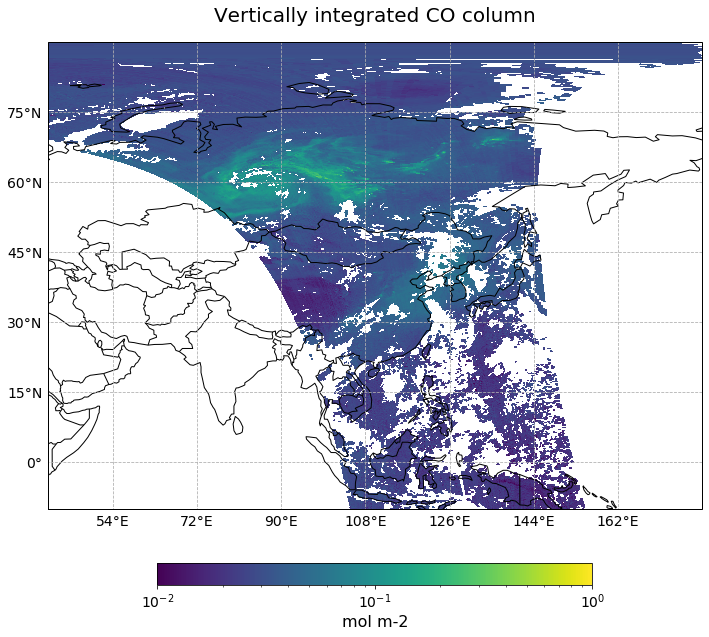

In [81]:
visualize_pcolormesh(co, lon, lat, 
                     ccrs.PlateCarree(), 
                     'viridis', 
                     unit, 
                     long_name, 
                     vmin, vmax, 
                     lonmin, lonmax, latmin, latmax, 
                     log=True, 
                     set_global=False)


## <a id='cams_gfas'></a>CAMS GFAS Wildfire Radiative Power

#### Load the data with xarray's `open_dataset`

The dataset contains the `Wildfire radiative power` for 7 days, starting on 23 July 2019. You can extract the `frpfire` variable and also store longname and unit, which will be needed later for visualizing the data.

In [82]:
gfas_frpfire_xr = xr.open_dataset('./eodata/cams/gfas/2019/07/23/20190723_wildfire_radiative_power.nc')
gfas_frpfire_xr

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 7)
Coordinates:
  * longitude  (longitude) float32 -179.95 -179.85 -179.75 ... 179.85 179.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-29
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-27 16:16:46 GMT by grib_to_netcdf-2.14.1: grib_to_n...

In [83]:
frpfire = gfas_frpfire_xr['frpfire']
longname = frpfire.long_name
unit = frpfire.units
frpfire

<xarray.DataArray 'frpfire' (time: 7, latitude: 1800, longitude: 3600)>
[45360000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.95 -179.85 -179.75 ... 179.85 179.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-29
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

#### Subset the data for Eastern Arctic region with `xarray.where` function

The wildfires occured over Siberia and the Arctic. Let's create a geographical subset, to highlight the fire occurrences for this specific region. You can use xarray's function `where` to do so.

In [84]:
latmin=-10
latmax=90
lonmin=40
lonmax=180
frpfire_subset = frpfire.where((frpfire.latitude < latmax) & (frpfire.latitude > latmin) & (frpfire.longitude < lonmax) & (frpfire.longitude > lonmin),drop=True)
frpfire_subset

<xarray.DataArray 'frpfire' (time: 7, latitude: 1000, longitude: 1400)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 40.05 40.15 40.25 ... 179.75 179.85 179.95
  * latitude   (latitude) float32 89.95 89.85 89.75 89.65 ... -9.75 -9.85 -9.95
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-29
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

#### Set negative values to `NaN`

The raw data can contain negative values, which you want to flag.

In [85]:
frpfire_subset.values[frpfire_subset.values<0]=np.nan

#### Visualise the Wildfire radiative power with the `visualize_pcolormesh`  function

Let's visualize the first day of the data set. You can change the value of time in the function below to visualize the `Wildfire Radiative Power` for subsequent days.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f66584d8470>)

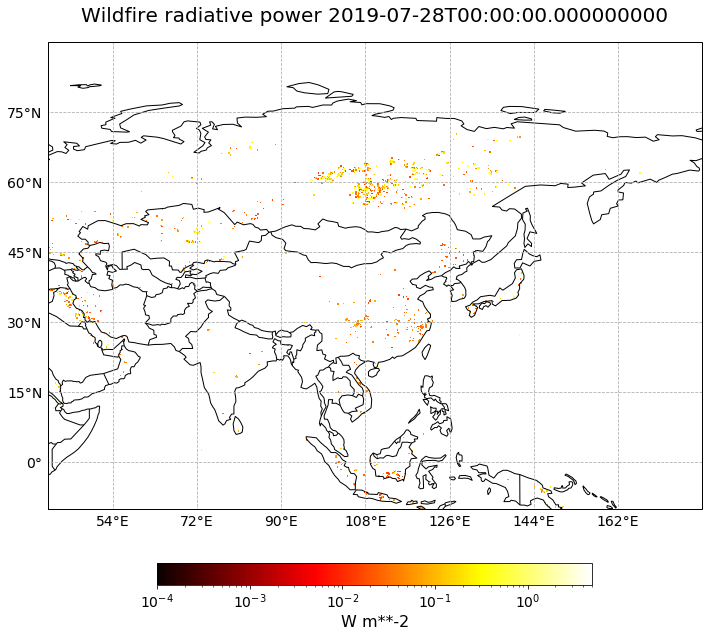

In [86]:
visualize_pcolormesh(frpfire_subset.isel(time=5).data, 
                     frpfire_subset.longitude.data, 
                     frpfire_subset.latitude.data, 
                     ccrs.PlateCarree(), 
                     'hot', 
                     unit, 
                     longname + ' ' + str(frpfire_subset.isel(time=5).time.data), 
                     0.0001, 5, 
                     lonmin, lonmax, latmin, latmax, 
                     log=True, 
                     set_global=False)
    

<br>

## <a id='cams_co'></a>CAMS Total column of carbon monoxide

#### Load the data with xarray's function `open_dataset`

You can see that the dataset contains the `Carbon monoxide` values for six days, starting on 23 July 2019. You can extract the `tcco` variable as well as information on title (long name) and unit. These will be required for the visualization at a later stage.

In [87]:
cams_co_tc_xr = xr.open_dataset('./eodata/cams/nrt/co/2019/07/23/20190723_fc_tc_co.nc')
cams_co_tc_xr

<xarray.Dataset>
Dimensions:    (latitude: 901, longitude: 1800, time: 6)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
  * latitude   (latitude) float32 90.0 89.8 89.6 89.4 ... -89.6 -89.8 -90.0
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-28
Data variables:
    tcco       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-27 16:09:08 GMT by grib_to_netcdf-2.14.1: grib_to_n...

In [88]:
tcco = cams_co_tc_xr['tcco']
tcco
longname = tcco.long_name
unit = tcco.units

#### Create a geographic subset for the area where the fires occured

You can create a geographic subset with xarray's function `where`.

In [89]:
latmin=-10
latmax=90
lonmin=40
lonmax=180
tcco_subset = tcco.where((tcco.latitude < latmax) & (tcco.latitude > latmin) & (tcco.longitude < lonmax) & (tcco.longitude > lonmin),drop=True)
tcco_subset

<xarray.DataArray 'tcco' (time: 6, latitude: 499, longitude: 699)>
array([[[0.00069466, 0.00069466, 0.00069466, ..., 0.00069955,
         0.00069955, 0.00069955],
        [0.00069099, 0.00069099, 0.00069099, ..., 0.0007023 ,
         0.000702  , 0.000702  ],
        [0.00068549, 0.00068549, 0.00068549, ..., 0.00070627,
         0.00070627, 0.00070627],
        ...,
        [0.00059259, 0.00058679, 0.00058251, ..., 0.00046149,
         0.00045844, 0.00045538],
        [0.00059045, 0.00058526, 0.0005819 , ..., 0.00046057,
         0.00045813, 0.00045507],
        [0.00059015, 0.00058526, 0.0005819 , ..., 0.00046057,
         0.00045782, 0.00045507]],

       [[0.00076373, 0.00076373, 0.00076373, ..., 0.00076831,
         0.00076862, 0.00076862],
        [0.00076312, 0.00076312, 0.00076312, ..., 0.0007677 ,
         0.0007677 , 0.0007677 ],
        [0.00076189, 0.00076189, 0.0007622 , ..., 0.00076648,
         0.00076648, 0.00076648],
        ...,
        [0.00059687, 0.00059534, 0.00059168, ..., 0.00048013,
         0.00048013, 0.00048044],
        [0.00059962, 0.0005984 , 0.00059504, ..., 0.00047952,
         0.00048013, 0.00048074],
        [0.00060237, 0.00060115, 0.00059748, ..., 0.0004786 ,
         0.00047922, 0.00047983]],

       [[0.0007512 , 0.0007512 , 0.0007512 , ..., 0.00073867,
         0.00073836, 0.00073836],
        [0.00075334, 0.00075334, 0.00075334, ..., 0.00073531,
         0.00073531, 0.000735  ],
        [0.00075609, 0.00075609, 0.00075609, ..., 0.00073011,
         0.00073011, 0.00073011],
        ...,
        [0.0006421 , 0.00064149, 0.00064088, ..., 0.00045935,
         0.00045263, 0.0004456 ],
        [0.00064057, 0.00063935, 0.00063965, ..., 0.00046485,
         0.00045874, 0.00045171],
        [0.00063935, 0.00063813, 0.00063843, ..., 0.00047066,
         0.00046485, 0.00045782]],

       [[0.00075884, 0.00075884, 0.00075884, ..., 0.00075425,
         0.00075425, 0.00075425],
        [0.00075914, 0.00075914, 0.00075914, ..., 0.00075364,
         0.00075364, 0.00075364],
        [0.00075914, 0.00075914, 0.00075914, ..., 0.00075242,
         0.00075242, 0.00075272],
        ...,
        [0.00061918, 0.00061337, 0.0006094 , ..., 0.00047249,
         0.00047371, 0.00047524],
        [0.0006201 , 0.00061368, 0.00060971, ..., 0.00046944,
         0.00047035, 0.00047188],
        [0.00062101, 0.0006149 , 0.00061062, ..., 0.00046669,
         0.0004676 , 0.00046882]],

       [[0.00099201, 0.00099201, 0.00099201, ..., 0.00102685,
         0.00102685, 0.00102685],
        [0.00098895, 0.00098926, 0.00098956, ..., 0.00103999,
         0.00103999, 0.00103968],
        [0.00098467, 0.00098498, 0.00098528, ..., 0.00105985,
         0.00105985, 0.00105954],
        ...,
        [0.00064027, 0.00063538, 0.00063232, ..., 0.00047677,
         0.00047585, 0.00047524],
        [0.00064149, 0.0006366 , 0.00063385, ..., 0.00047708,
         0.00047616, 0.00047555],
        [0.0006424 , 0.00063782, 0.00063476, ..., 0.0004783 ,
         0.00047738, 0.00047647]],

       [[0.00095748, 0.00095748, 0.00095748, ..., 0.00092997,
         0.00092997, 0.00092967],
        [0.00096481, 0.00096481, 0.00096511, ..., 0.00091744,
         0.00091744, 0.00091744],
        [0.00097581, 0.00097612, 0.00097642, ..., 0.0008988 ,
         0.0008988 , 0.00089849],
        ...,
        [0.00063751, 0.00063507, 0.00063385, ..., 0.00047219,
         0.00047188, 0.00047188],
        [0.00063568, 0.00063354, 0.00063263, ..., 0.00047188,
         0.00047158, 0.00047158],
        [0.00063415, 0.00063201, 0.0006311 , ..., 0.00047188,
         0.00047158, 0.00047127]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 40.2 40.4 40.6 40.8 ... 179.4 179.6 179.8
  * latitude   (latitude) float32 89.8 89.6 89.4 89.2 ... -9.2 -9.4 -9.6 -9.8
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-28
Attributes:
    units:      kg m**-2
    long_name:  Total column Carbon monoxide

#### Visualize the Carbon monoxide total column with the function `visualize_pcolormesh`

Let's visualize the first day (23 July 2019) of the dataset with the help of the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f662e7e1cc0>)

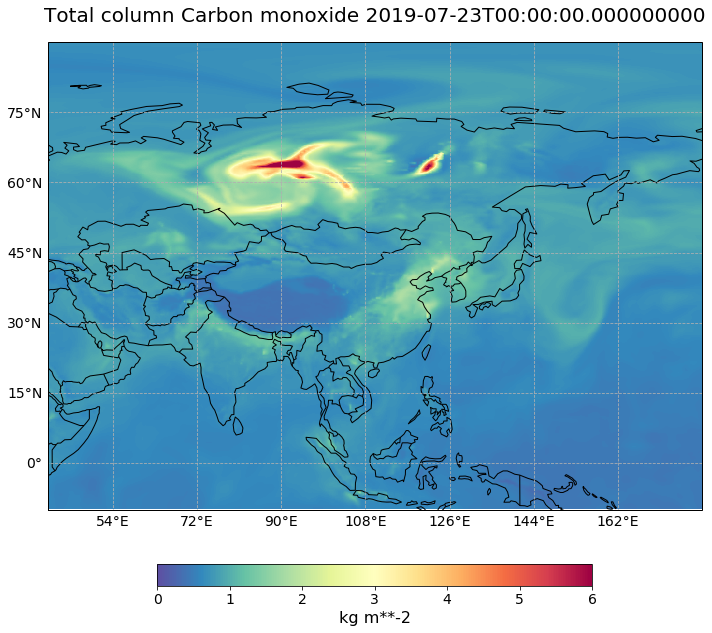

In [90]:
visualize_pcolormesh(tcco_subset.isel(time=0).data*1000, 
                     tcco_subset.longitude.data, 
                     tcco_subset.latitude.data, 
                     ccrs.PlateCarree(), 
                     'Spectral_r', 
                     unit, 
                     longname + ' ' + str(tcco_subset.isel(time=0).time.data), 
                     0, 6, 
                     lonmin, lonmax, latmin, latmax, 
                     log=False, 
                     set_global=False)


<br>

## <a id='geff_fwi'></a>GEFF Fire Weather Index

### Assess fire danger using harmonised danger classes

Raw Fire Weather Index (FWI) forecast values are expressed as a continuous rating in the range [0, +Inf[, very rarely values exceed 100. In order to aid decision making, fire danger is routinely mapped into 6 classes (very low, low, moderate, high, very high and extreme), before being displayed by the GWIS viewer.

![GWIS](./img/screenshot-gwis.jrc.ec.europa.eu-2020.05.07-09_44_51.png)

In this tutorial we are going to look at the temporal evolution of the fire danger forecast and its predictive capability. We will use the forecast issued on _14th July 2019_ to see whether dangerous fire weather could have been predicted **10 days ahead** in the area where the Siberian fires started burning on _23rd July 2019_. We will repeat the same procedure at **5 days leadtime** (issue date _19th July 2019_) and **2 days leadtime** (issue date _22nd July 2019_). For convenience, a schematic representation of the forecast issue dates and leadtimes is provided in the table below.

![Leadtimes](./img/screenshot-docs.google.com-2020.05.07-10_06_59.png)

In order to assess fire danger in a harmonized way throughout the Artic region, we make use of the **Canadian** threshold levels:
  - Very Low = 0-2,
  - Low = 2-5,
  - Moderate = 5-9,
  - High = 9-17,
  - VeryHigh = 17-30,
  - Extreme >= 30

### RT HRES fire danger forecast issued on 14th July 2019

In [92]:
# Open raw RT HRES forecast for issued on 14th July 2019 (9 days before the the start of Siberian fires)
ds = xr.open_dataset("./eodata/geff/siberia/rt_hr/ECMWF_FWI_20190714_1200_hr_fwi_rt.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 1422, lon: 1992, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2019-07-14 2019-07-15 ... 2019-07-23
  * lon      (lon) float32 40.007812 40.078125 40.148438 ... 179.92969 180.0
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -9.876977 -9.947276
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Mon May 04 17:36:15 2020: cdo --silent sellonlatbox,40...
    Conventions:       CF-1.6
    Reference date:    20190714
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f662be9f358>)

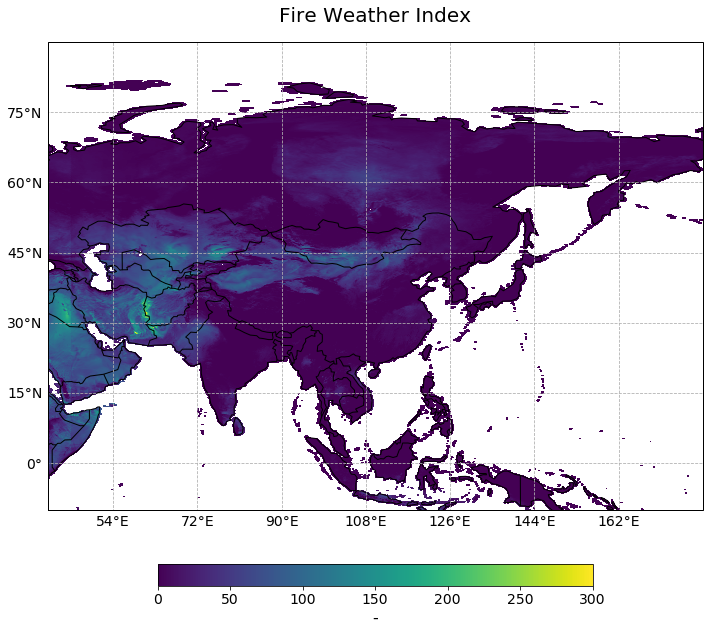

In [93]:
# Plot the raw forecast, Day 10
visualize_pcolormesh(ds.fwi[9],
                     ds.fwi[9].lon,
                     ds.fwi[9].lat,
                     ccrs.PlateCarree(),
                     'viridis',
                     ds.fwi[9].units,
                     ds.fwi[9].title,
                     0,
                     300,
                     40,
                     180,
                     -9.94,
                     89.94,
                     log=False,
                     set_global=False)

From the above plot it is not easy to distinguish values below 100. The color ramp needs to be rescaled.

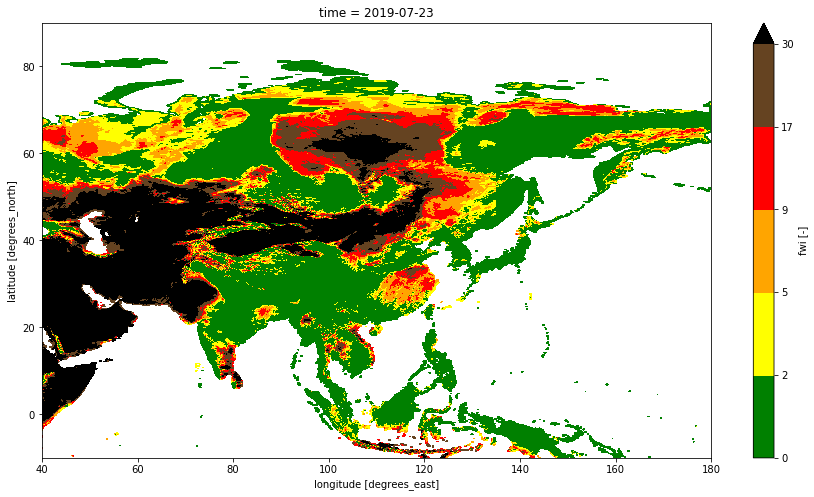

In [94]:
# Plot the re-classified forecast, Day 10
ds.fwi[9].plot(levels = [0.0, 2.0, 5.0, 9.0, 17.0, 30.0],
               colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
               label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'],
              figsize=(15,8))

Fire danger was predicted to be high-to-extreme 10 days ahead!

### RT HRES fire danger forecast issued on 19th July 2019

In the fire danger forecast issued on 19th July, the area interested by very high-to-extreme danger expanded to the North and East of the Siberian region.

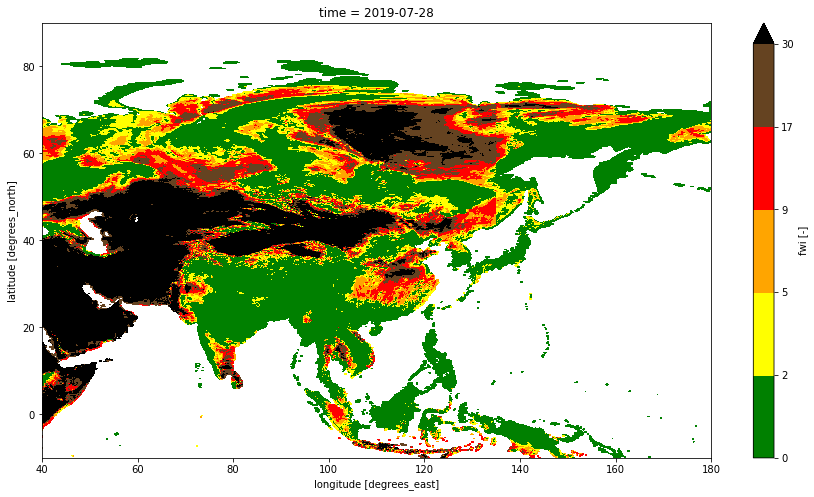

In [95]:
# Open raw RT HRES forecast for issued on 19th July 2019 (4 days before the the start of Siberian fires)
ds = xr.open_dataset("./eodata/geff/siberia/rt_hr/ECMWF_FWI_20190719_1200_hr_fwi_rt.nc")


# Plot the re-classified forecast
ds.fwi[9].plot(levels = [0.0, 2.0, 5.0, 9.0, 17.0, 30.0],
               colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
               label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'],
              figsize=(15,8));

### RT HRES fire danger forecast issued on 22nd July 2019

The fire danger forecast issued on 22nd July confirms very high-to-extreme danger in the area were fire started on 23rd July.

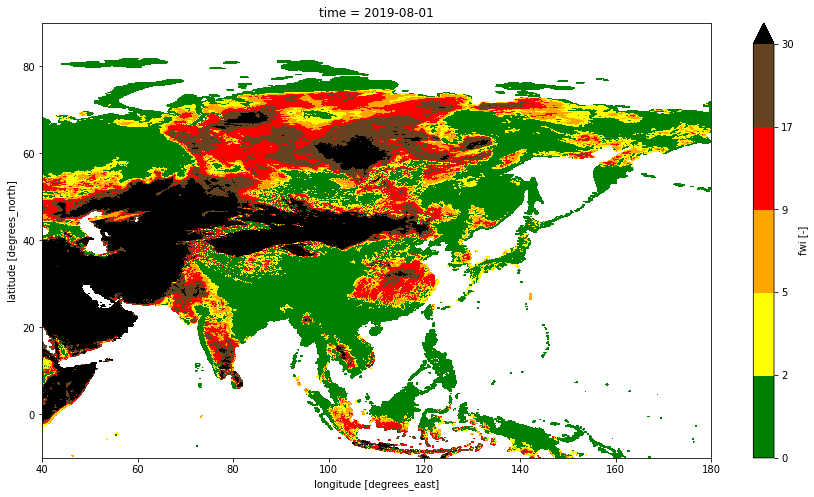

In [96]:
# Open raw RT HRES forecast for issued on 22nd July 2019 (1 day before the the start of Siberian fires)
ds = xr.open_dataset("./eodata/geff/siberia/rt_hr/ECMWF_FWI_20190723_1200_hr_fwi_rt.nc")

# Plot the re-classified forecast
ds.fwi[9].plot(levels = [0.0, 2.0, 5.0, 9.0, 17.0, 30.0],
               colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
               label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'],
              figsize=(15,8));

<br>

## <a id='lsa_saf'></a>LSA SAF data products for fire monitoring

### <a id='lsa_saf_fapar'></a>LSA SAF ETfAPAR - 25 July 2019

Load the `HDF5` LSA SAF ETfAPAR file for Siberia for 25 July 2019

In [97]:
file_name = './eodata/lsa_saf/siberia/HDF5_LSASAF_M01-AVHR_ETFAPAR_SIBERIA_201907250000'
file = h5py.File(file_name,'r')

for item in file.items():
    print(item)

('FAPAR', <HDF5 dataset "FAPAR": shape (4501, 10608), type "<i2">)
('FAPAR QF', <HDF5 dataset "FAPAR QF": shape (4501, 10608), type "|i1">)
('FAPAR err', <HDF5 dataset "FAPAR err": shape (4501, 10608), type "<i2">)
('LAT', <HDF5 dataset "LAT": shape (4501, 10608), type "<i2">)
('LON', <HDF5 dataset "LON": shape (4501, 10608), type "<i2">)
('Z_Age', <HDF5 dataset "Z_Age": shape (4501, 10608), type "|i1">)


Retrieve the `FAPAR` parameter with the function `get()`

In [98]:
fapar = file.get('FAPAR')
fapar

<HDF5 dataset "FAPAR": shape (4501, 10608), type "<i2">

Define `missing value` and `scaling factor`

In [99]:
missing_value = fapar.attrs['MISSING_VALUE']
missing_value

scaling_factor=10000.

Mask out the `missing value` and apply the `scaling factor`

In [101]:
fapar_masked = np.ma.masked_values(fapar, missing_value)
fapar_masked = fapar_masked / scaling_factor
fapar_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.5983, 0.6615, 0.627, ..., --, --, --],
        [0.6296, 0.6745, 0.6647, ..., --, --, --],
        [0.7456, 0.7142, 0.665, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=-10)

Visualize the `ETfAPAR` information for Siberia for 25 July 2019

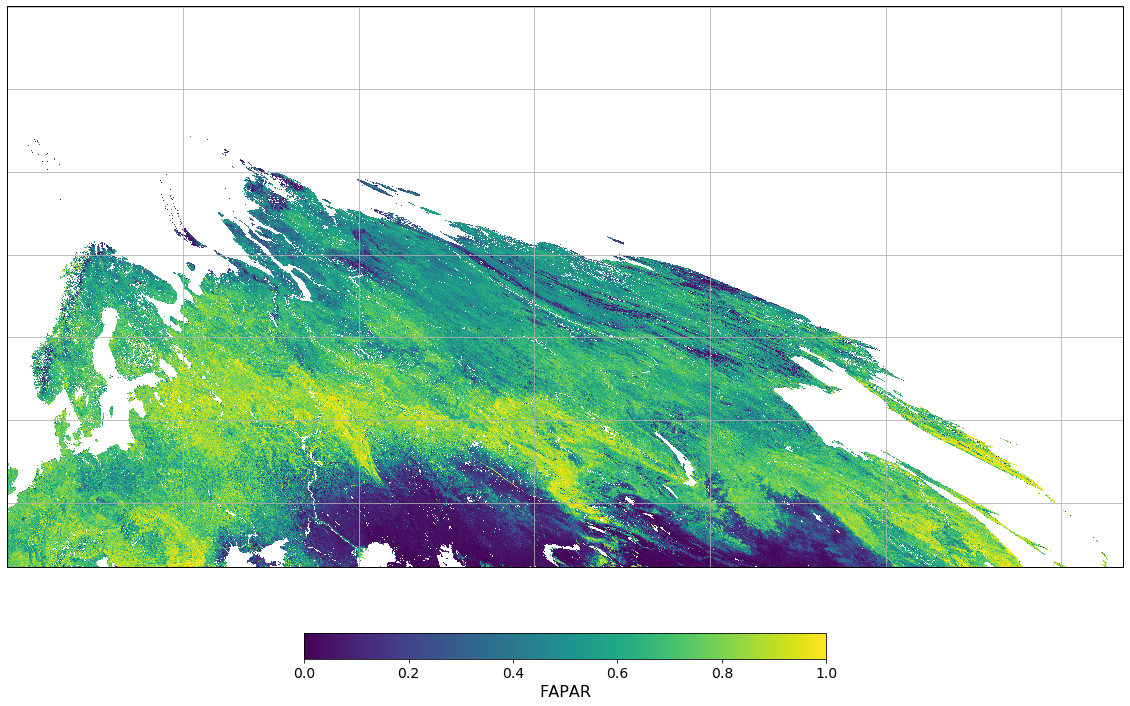

In [102]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()

img1 = plt.imshow(fapar_masked,
                          cmap='viridis',
                          vmin=0,
                          vmax=1,
                          aspect='auto')

cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('FAPAR',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

### <a id='lsa_saf_lst'></a>LSA SAF EDLST DAY - 25 July 2019

Load the `HDF5` file of the `LSA SAF EDLST DAY` data

In [103]:
file = h5py.File('./eodata/lsa_saf/siberia/HDF5_LSASAF_M01-AVHR_EDLST-DAY_SIBERIA_201907250000', 'r')
file

for item in file.items():
    print(item)

('LAT', None)
('LON', <HDF5 dataset "LON": shape (4501, 10608), type "<i2">)
('LST-day', <HDF5 dataset "LST-day": shape (4501, 10608), type "<i2">)
('QFLAG-day', <HDF5 dataset "QFLAG-day": shape (4501, 10608), type "|i1">)
('VZA-day', <HDF5 dataset "VZA-day": shape (4501, 10608), type "|i1">)
('aquisition_time-day', <HDF5 dataset "aquisition_time-day": shape (4501, 10608), type "<i2">)
('n-day', <HDF5 dataset "n-day": shape (4501, 10608), type "|i1">)


Retrieve the `LST-day` parameter

In [104]:
lst_day = file.get('LST-day')
lst_day

<HDF5 dataset "LST-day": shape (4501, 10608), type "<i2">

Define `missing value` and `scaling factor`

In [105]:
missing_value = lst_day.attrs['MISSING_VALUE']
scaling_factor = lst_day.attrs['SCALING_FACTOR']
missing_value, scaling_factor

(-29999, 100.0)

Mask out `missing value` and apply `scaling factor`

In [106]:
lst_day_masked = np.ma.masked_values(lst_day, missing_value)
lst_day_masked = lst_day_masked / scaling_factor
lst_day_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [39.58, 39.53, 37.45, ..., --, --, --],
        [38.4, 36.23, 35.63, ..., --, --, --],
        [37.5, 36.17, 39.22, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=-29999)

Visualize the `LST-Day` values for Siberia for 25 July 2019

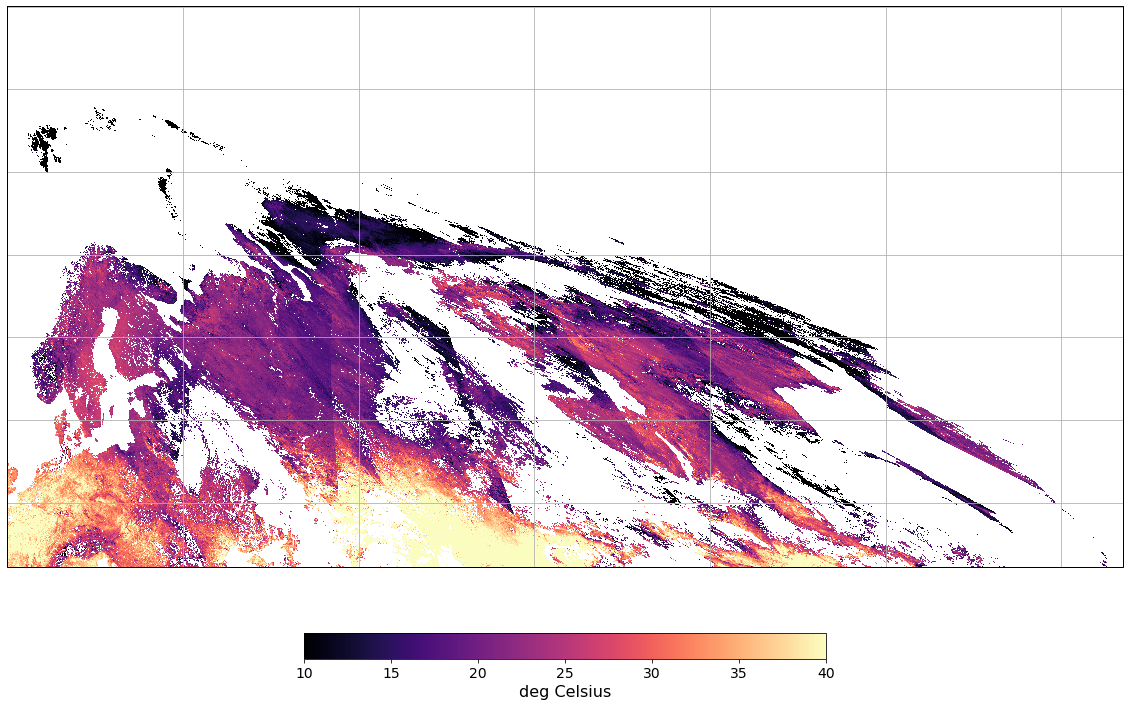

In [107]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()

img1 = plt.imshow(lst_day_masked,
                          cmap='magma',
                          vmin=10,
                          vmax=40,
                          aspect='auto')

cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('deg Celsius',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

### LSA SAF EDLST Night - 25 July 2019

Load the `HDF5` file of `LSA SAF EDLST Night` for Siberia for 26 July 2019

In [108]:
file = h5py.File('./eodata/lsa_saf/siberia/HDF5_LSASAF_M01-AVHR_EDLST-NIGHT_SIBERIA_201907260000', 'r')
file

for item in file.items():
    print(item)

('LAT', <HDF5 dataset "LAT": shape (4501, 10608), type "<i2">)
('LON', <HDF5 dataset "LON": shape (4501, 10608), type "<i2">)
('LST-night', <HDF5 dataset "LST-night": shape (4501, 10608), type "<i2">)
('QFLAG-night', <HDF5 dataset "QFLAG-night": shape (4501, 10608), type "|i1">)
('VZA-night', <HDF5 dataset "VZA-night": shape (4501, 10608), type "|i1">)
('aquisition_time-night', <HDF5 dataset "aquisition_time-night": shape (4501, 10608), type "<i2">)
('n-night', <HDF5 dataset "n-night": shape (4501, 10608), type "|i1">)


Retrieve the `LST-night` parameter

In [109]:
lst_night = file.get('LST-night')
lst_night


<HDF5 dataset "LST-night": shape (4501, 10608), type "<i2">

Define `missing value` and `scaling factor`

In [110]:
missing_value = lst_night.attrs['MISSING_VALUE']
scaling_factor = lst_night.attrs['SCALING_FACTOR']
missing_value, scaling_factor

(-29999, 100.0)

Mask out `missing value` and apply `scaling factor`

In [111]:
lst_night_masked = np.ma.masked_values(lst_night, missing_value)
lst_night_masked = lst_night_masked / scaling_factor
lst_night_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-29999)

Visualize the `LST-night` values for Siberia for 26 July 2019

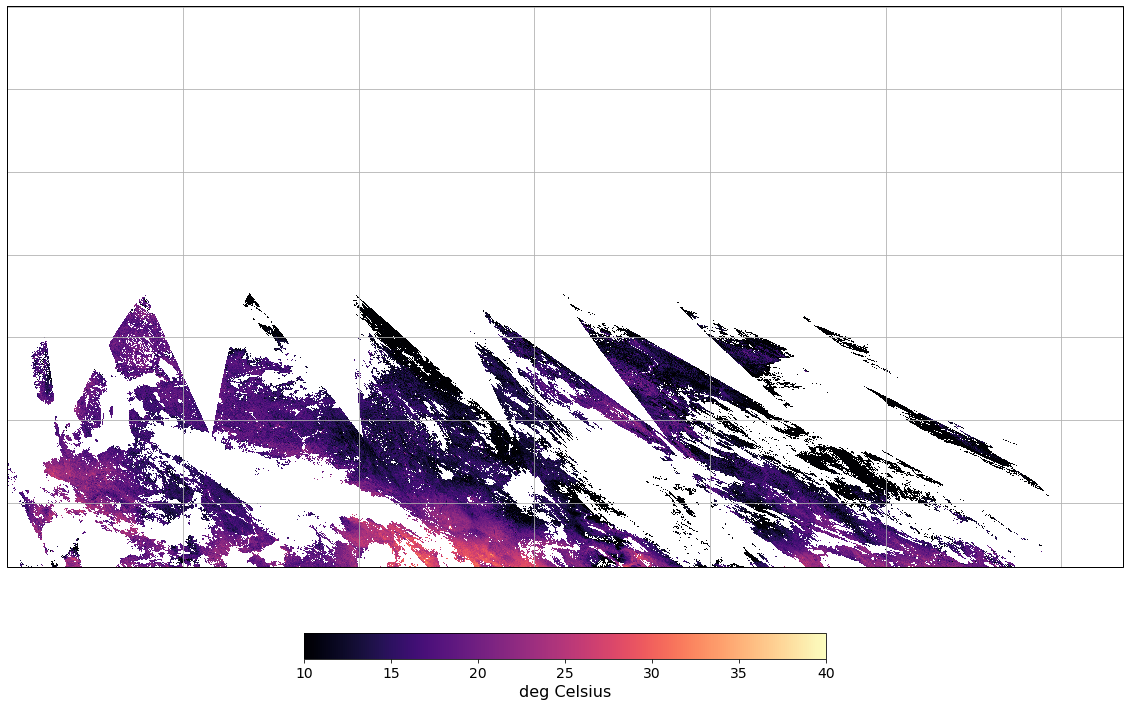

In [112]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()

img1 = plt.imshow(lst_night_masked,
                          cmap='magma',
                          vmin=10,
                          vmax=40,
                          aspect='auto')

cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('deg Celsius',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

### LSA SAF NDVI - 21 July 2019

Define path to `img` file

In [113]:
file = './eodata/lsa_saf/siberia/METOP_AVHRR_20190721_S10_ASn_NDV.img'

Load file metadata into a Python dictionary

In [114]:
hdr = os.path.splitext(file)[0]+'.hdr'
hdr
hdr_set = {}

myfileobj = open(hdr, "r")    
for line in myfileobj.readlines():   
    line = [x.strip() for x in line.split(' = ')]
    if len(line) > 1:
        if line[0] == 'values':
            line[0] = 'VALUES'
        hdr_set[line[0]] = line[1]

hdr_set

{'description': '{METOP-AVHRR, 10-daily synthesis, 20190721-20190731, NDVI, processing by VITO-Belgium }',
 'samples': '15120',
 'lines': '3920',
 'bands': '1',
 'interleave': 'BSQ',
 'file type': 'ENVI Standard',
 'data type': '1',
 'sensor type': 'METOP-AVHRR',
 'map info': '{ Geographic Lat/Lon, 1.5, 1.5, 45.0, 75.0,  0.0089285714,  0.0089285714, WGS-84, units=Degrees }'}

Define `dtype` (data type) of the file

In [115]:
hdrdtype =  hdr_set['data type'] #get datatype from hdr_set
envidtypelib = hdrdtypelib()
dtype = envidtypelib[hdrdtype]

Load data file as `numpy.array` and reshape it to 2-dimensional

In [116]:
#get DN from image
data=np.fromfile(file,dtype=dtype)
#convert to 2D array
data.shape=(-1,int(hdr_set['samples']))
data

#Convert to float64 datatype
data_2 = np.float64(data)
data_2

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [207., 213., 210., ..., 255., 255., 255.],
       [208., 212., 198., ..., 255., 255., 255.],
       [195., 200., 199., ..., 255., 255., 255.]])

Apply `missing value` and `scaling factor`

In [117]:
missing_value = np.max(data_2)
data_masked = np.ma.masked_values(data_2, missing_value)
data_masked_4 = 0.004*data_masked-0.08
data_masked_4

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.7480000000000001, 0.772, 0.76, ..., --, --, --],
        [0.7520000000000001, 0.768, 0.7120000000000001, ..., --, --, --],
        [0.7000000000000001, 0.7200000000000001, 0.7160000000000001, ...,
         --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=255.0)

Visualize the `NDVI` for Siberia for 21 July 2019 with matplotlib's `imshow()` function

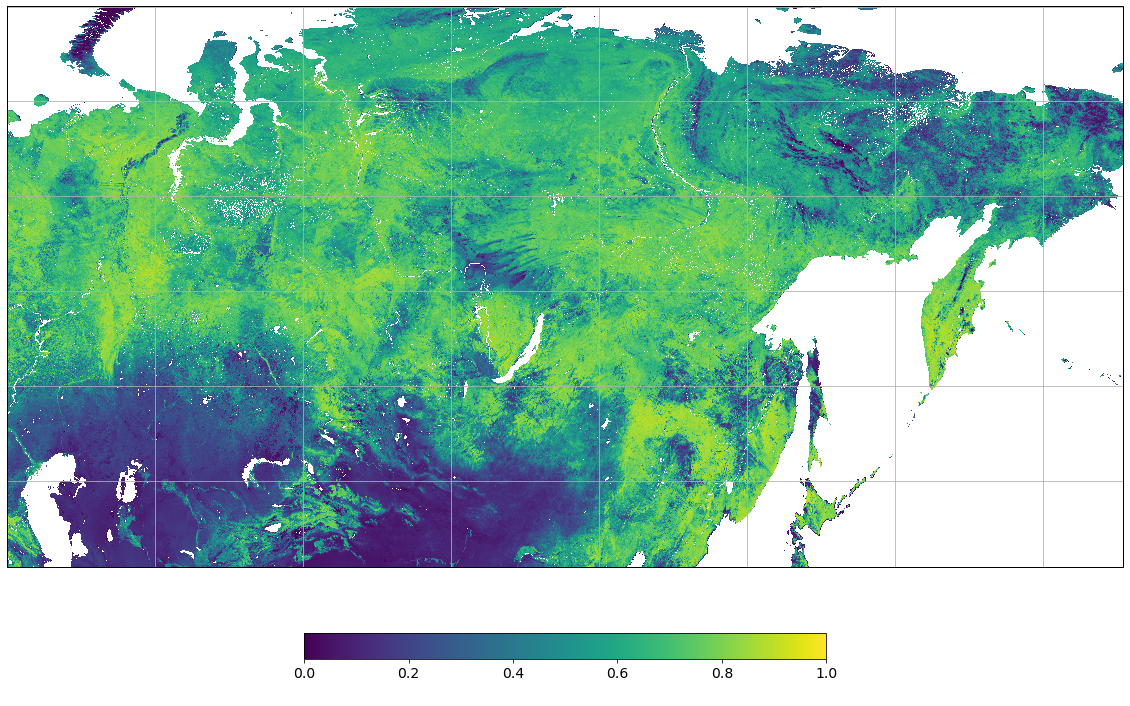

In [118]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()


img1 = plt.imshow(data_masked_4,
                          vmin=0,
                          vmax=1,
                          aspect='auto')


cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(' ',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

<br>

## <a id='sentinel3_olci'></a>Sentinel-3 OLCI Level 1 RGB

Sentinel-3 OLCI Level 1 RGB composites can highlight areas of smoke resulting from wildfires. Let's go through step by step to load Sentinel-3 OLCI Level 1 data and to build a RGB false color composite.

#### Load OLCI channel information into one xarray object with xarray's function `open_mfdataset`

You can load mulitple files at once with `open_mfdataset`. In the case of Sentinel-3 OLCI Level-1 data, you want to combine the data of all 21 channels into one xarray object. The structure of the single data files is equal, thus you can combine the data by coordinates by using the keyword argument `by_coords`.

In [119]:
olci_dir = './eodata/sentinel3/olci/2019/07/25/S3A_OL_1_EFR____20190725T023002_20190725T023302_20190726T055350_0179_047_203_1980_LN1_O_NT_002.SEN3/'


In [120]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4090)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa10_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa11_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa12_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa13_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa14_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa15_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  17886
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2019-07-26T05:53:50Z
    history:                  2019-07-26T05:53:50Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20190725T023002_20190725T023302_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2019-07-25T02:30:01.566131Z
    stop_time:              2019-07-25T02:33:01.487087Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load the geo-coordinates and retrieve the data for `latitude` and `longitude`

You might want to georeference the resulting RGB image. Thus, you can already load the `geo_coordinates.nc` file and retrieve `latitude` and `longitude` information.

In [121]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

#### Select the channels for the RGB composite

The function [select_channels_for_rgb](./ltpy_functions.ipynb#rgb_channels) selects the chosen channels from the loaded xarray object. In this case, we select the channels #17, #05 and #02. Those channels allow to build a false color composite that highlights healthy vegetation in red and also shows the fire smokes more prominently.

In [122]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')


#### Normalize the channels `red`, `green` and `blue`

The function [normalize](./ltpy_functions.ipynb#normalize) normalizes the data values within a range between 0 and 1.

In [123]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

#### Stack the RGB channels into a multi-dimensional array with `np.dstack`

In [124]:
rgb = np.dstack((redn, greenn, bluen))

#### Apply a histogram equalization 

A histogram equalization can improve the contrast of the resulting RGB composite. Thus, we use the `exposure` function from the ski-kit-learn library to equalize the image based on the data's histogram.

In [125]:
rgb = exposure.equalize_adapthist(rgb)

#### Map the rgb values onto a color array

If you want to visualize a georeferenced RGB image, you have to map the rgb values onto a color array with the following code:

In [126]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

#### Visualize the final RGB false color composite with the function `visualize_s3_pcolormesh`

Let's visualize the color array in a georeferenced way with matplotlib's function `pcolormesh`.

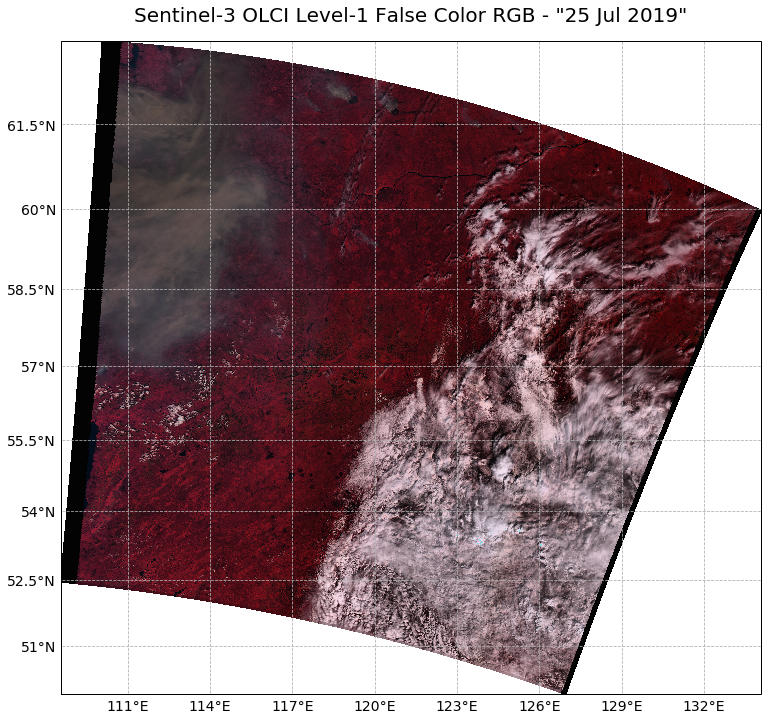

In [127]:
visualize_s3_pcolormesh(colorTuple, 
                        red, lat, lon, 
                        'Sentinel-3 OLCI Level-1 False Color RGB - "25 Jul 2019"')

<br>

<br>

<a href="./52_sentinel3_olci_rgb.ipynb"><< 52 - Sentinel 3 OLCI RGB </a><span style="float:right;"><a href="./62_case_study_sweden_fires_summer_2018_self_paced.ipynb">62 - Case study Sweden Fires - Summer 2018 >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.